# Visualization of bird sound files

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Conversion:-MP3-to-WAV" data-toc-modified-id="Conversion:-MP3-to-WAV-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conversion: MP3 to WAV</a></span></li><li><span><a href="#Import-metadata" data-toc-modified-id="Import-metadata-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Import metadata</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Temporal-representation" data-toc-modified-id="Temporal-representation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Temporal representation</a></span></li><li><span><a href="#Frequency-representation-(2D-spectrogram)" data-toc-modified-id="Frequency-representation-(2D-spectrogram)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Frequency representation (2D spectrogram)</a></span></li></ul></li><li><span><a href="#Analyze-Kasios-test-birds-with-visualizations" data-toc-modified-id="Analyze-Kasios-test-birds-with-visualizations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze Kasios test birds with visualizations</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Blue-Pipit-songs" data-toc-modified-id="Blue-Pipit-songs-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Blue Pipit songs</a></span></li><li><span><a href="#Blue-Pipit-calls" data-toc-modified-id="Blue-Pipit-calls-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Blue Pipit calls</a></span></li></ul></li><li><span><a href="#Kasios-files" data-toc-modified-id="Kasios-files-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Kasios files</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pydub import AudioSegment
from scipy import signal
from scipy.io import wavfile

In [2]:
# custom matplotlib style
usetex = True
fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize}
      #'text.usetex': usetex} # Requires latex on the computer
plt.style.use('ggplot')
plt.rcParams.update(params)

## Pre-processing

### Conversion: MP3 to WAV

Here, we take all the MP3 bird sounds inside the "ALL BIRDS" and "Test Birds from Kasios" folders, and convert them into WAV files. 

We have to do this because WAV is the most supported format to do sound processing.

**Please put the folders "ALL BIRDS" and "Test Birds from Kasios" of [the VAST challenge](http://www.vacommunity.org/VAST+Challenge+2018+MC1) at the root of this notebook.**

<div class='alert alert-warning'>
This step will take some minutes. 
<div>

In [11]:
from data.loader import get_kasios_obs, get_obs, map_path

df = get_obs(songs = True)
df_kasios = get_kasios_obs(songs = True)

Loading wav files...
Done.
Loading wav files...
Done.


## Visualization

### Temporal representation 

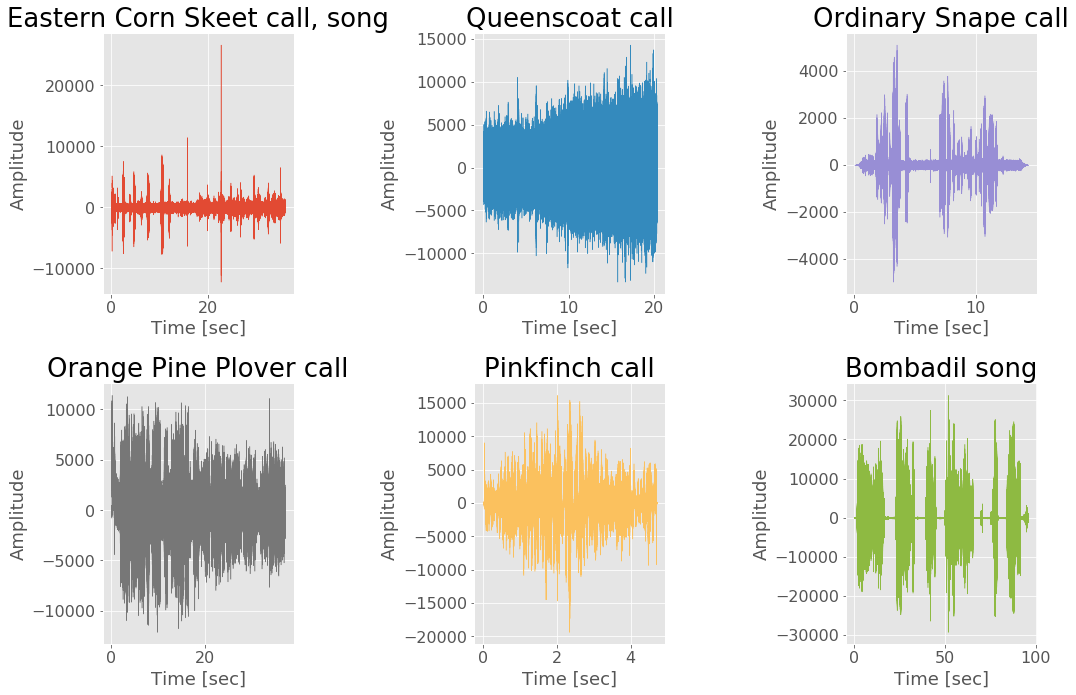

In [4]:
# take random samples
samples = df.sample(6)

fig = plt.figure(figsize=(15,10))
for i, (index, obs) in enumerate(samples.iterrows()):
    # read wav file
    rate, data = wavfile.read(obs["song"])
    
    times = np.arange(len(data))/float(rate)
    title = '{} {}'.format(obs["English_name"], obs["Vocalization_type"])
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.fill_between(times, data, color="C{}".format(i)) # plot the signal
    ax.set_title(title)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Amplitude')

plt.tight_layout()

### Frequency representation (2D spectrogram)

/home/nicolas/anaconda3/envs/vast/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


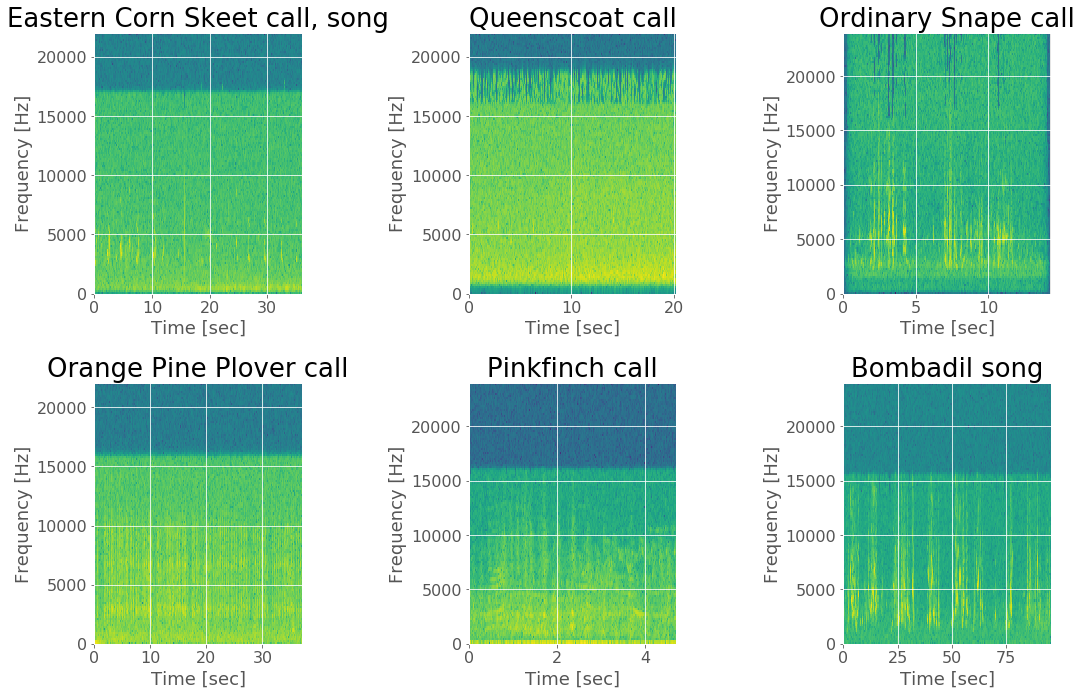

In [5]:
fig = plt.figure(figsize=(15,10))
for i, (index, obs) in enumerate(samples.iterrows()):
    # read wav file
    rate, data = wavfile.read(obs["song"])
    
    times = np.arange(len(data))/float(rate)
    title = '{} {}'.format(obs["English_name"], obs["Vocalization_type"])
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.specgram(data, Fs=rate)
    ax.set_title(title)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Frequency [Hz]')
    
plt.tight_layout()

## Analyze Kasios test birds with visualizations

Kasios provided 15 birds sounds. According to them, they are songs and calls from the Rose-crested Blue Pipit species. 

**Aim**:  Analyse the Kasios birds tests records and verify from which species each record belongs.


The dataset we have been provided contains **186** samples of Rose-crested Blue Pipits sounds. They are **"songs"** and **"calls"**, with different qualities, graded from A to E. Most of them are in good quality. In fact, quality A and B represent **148** records.


We will first visualize some of the Blue Pipits records to identify some characteristics, and then we will compare what we obtained with the Kasios records. 

To do the comparison, we will plot all the records with the same scales. The time (x-axis) will go from 0 to 20 seconds, and the amplitude (y-axis) from -10000 to 10000. 

In [6]:
def plot_signal_temp(df, title):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle(title)
    for i, (index, obs) in enumerate(df.iterrows()):
        # read wav file
        rate, data = wavfile.read(obs["song"])

        times = np.arange(len(data))/float(rate)
        title = '{} {}'.format(obs["English_name"], obs["Vocalization_type"])
        
        # plot the signal
        ax = fig.add_subplot(3, 3, i+1)
        times = np.arange(len(data))/float(rate)
        ax.fill_between(times, data, color="C{}".format(i))
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Amplitude')
        ax.set_xlim(0, 20)
        ax.set_ylim(-10000, 10000)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
def plot_spectrogram(df, title):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle(title)
    for i, (index, obs) in enumerate(df.iterrows()):
        # read wav file
        rate, data = wavfile.read(obs["song"])

        times = np.arange(len(data))/float(rate)
        title = '{} {}'.format(obs["English_name"], obs["Vocalization_type"])

        # plot the spectrogram
        ax = fig.add_subplot(3, 3, i+1)
        ax.specgram(data, Fs=rate)
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlim(0, 20)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Blue Pipit songs

,English_name,Vocalization_type,Quality,Time,Date,X,Y,color,T,song
File ID,,,,,,,,,,
405548,Rose-crested Blue Pipit,song,A,11:00,3/10/2018,55,125,#bcbd22,2018-03-10,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
401782,Rose-crested Blue Pipit,song,A,6:00,6/29/2008,129,123,#bcbd22,2008-06-29,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
377874,Rose-crested Blue Pipit,song,A,7:43,6/11/2000,134,118,#bcbd22,2000-06-11,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
364567,Rose-crested Blue Pipit,song,A,7:00,4/14/2017,124,121,#bcbd22,2017-04-14,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
293914,Rose-crested Blue Pipit,song,A,7:19,6/5/2015,142,114,#bcbd22,2015-06-05,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
277989,Rose-crested Blue Pipit,song,A,20:31,5/26/2015,159,117,#bcbd22,2015-05-26,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
277952,Rose-crested Blue Pipit,song,A,15:34,5/26/2015,128,116,#bcbd22,2015-05-26,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
176636,Rose-crested Blue Pipit,song,A,7:40,6/6/2013,121,132,#bcbd22,2013-06-06,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
164501,Rose-crested Blue Pipit,song,A,17:30,5/3/1993,131,120,#bcbd22,1993-05-03,/home/nicolas/Desktop/vast-challenge-2018-mc1/...


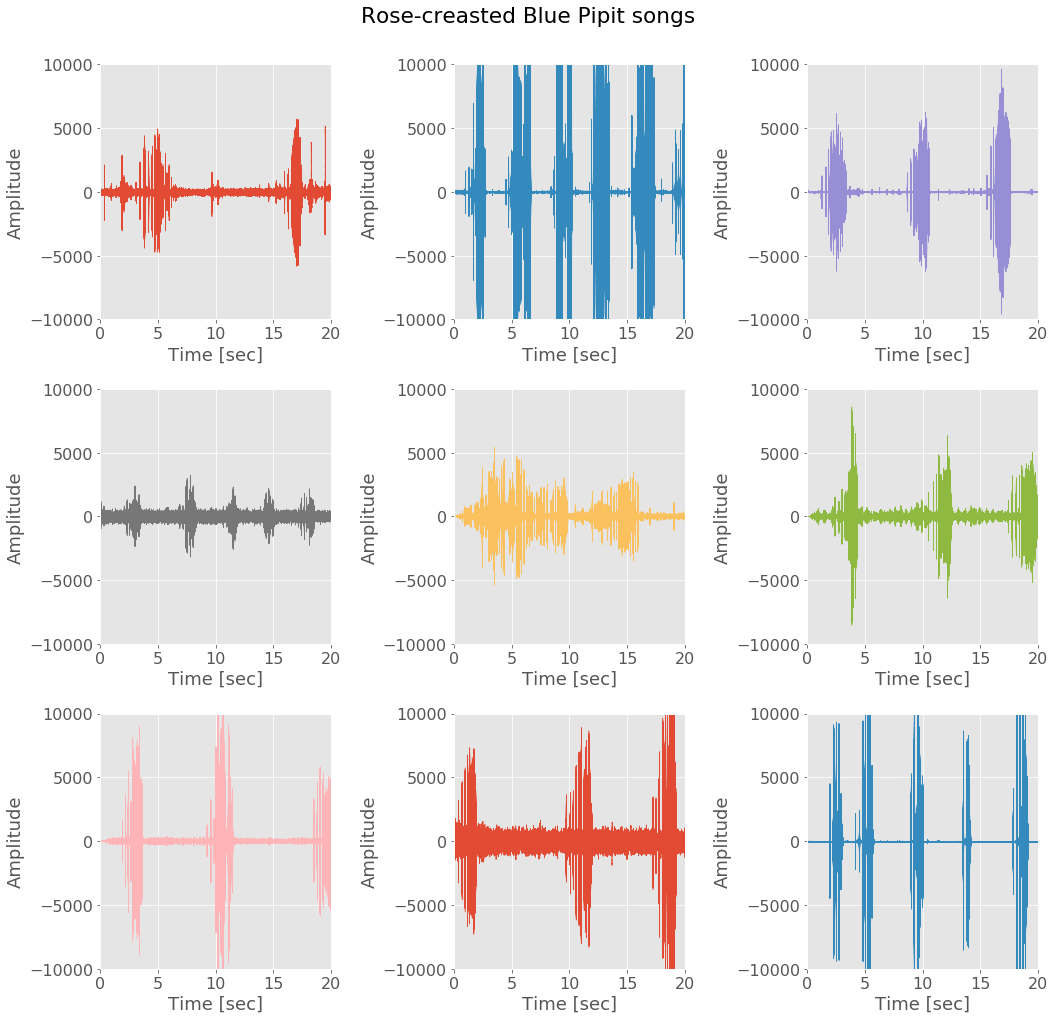

In [7]:
df_bp_songs = df.loc[(df['English_name'] == 'Rose-crested Blue Pipit') 
                     & (df['Vocalization_type'] == 'song')
                     & (df['Quality'] == 'A')]
df_bp_songs = df_bp_songs[:9]


display(df_bp_songs)

plot_signal_temp(df_bp_songs, 
                 title='Rose-creasted Blue Pipit songs')

<div class='alert alert-info'>
We notice that the songs of the Blue Pipit consist in <strong>sequences of "song - silence" repetitions</strong>, that occur at <strong>intervals of equal length</strong>. 
<br>
In the different records, the time of silence varies, but the <strong>time of the songs is approximately the same (2 seconds).</strong> 
<br>
The amplitude of the song periods is going <strong>crescendo</strong>. 
</div>

#### Blue Pipit calls

,English_name,Vocalization_type,Quality,Time,Date,X,Y,color,T,song
File ID,,,,,,,,,,
406171,Rose-crested Blue Pipit,call,A,7:48,6/7/2017,125,133,#bcbd22,2017-06-07,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
405901,Rose-crested Blue Pipit,call,A,12:00,2/8/2018,58,76,#bcbd22,2018-02-08,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
401720,Rose-crested Blue Pipit,call,A,13:00,12/28/2016,132,121,#bcbd22,2016-12-28,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
401719,Rose-crested Blue Pipit,call,A,13:00,12/28/2016,106,107,#bcbd22,2016-12-28,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
387404,Rose-crested Blue Pipit,call,A,10:00,9/18/2017,149,115,#bcbd22,2017-09-18,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
368493,Rose-crested Blue Pipit,call,A,12:47,3/13/2017,89,131,#bcbd22,2017-03-13,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
368492,Rose-crested Blue Pipit,call,A,12:45,3/13/2017,141,124,#bcbd22,2017-03-13,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
353709,Rose-crested Blue Pipit,call,A,?,10/8/2016,127,119,#bcbd22,2016-10-08,/home/nicolas/Desktop/vast-challenge-2018-mc1/...
351273,Rose-crested Blue Pipit,call,A,13:00,1/17/2017,146,114,#bcbd22,2017-01-17,/home/nicolas/Desktop/vast-challenge-2018-mc1/...


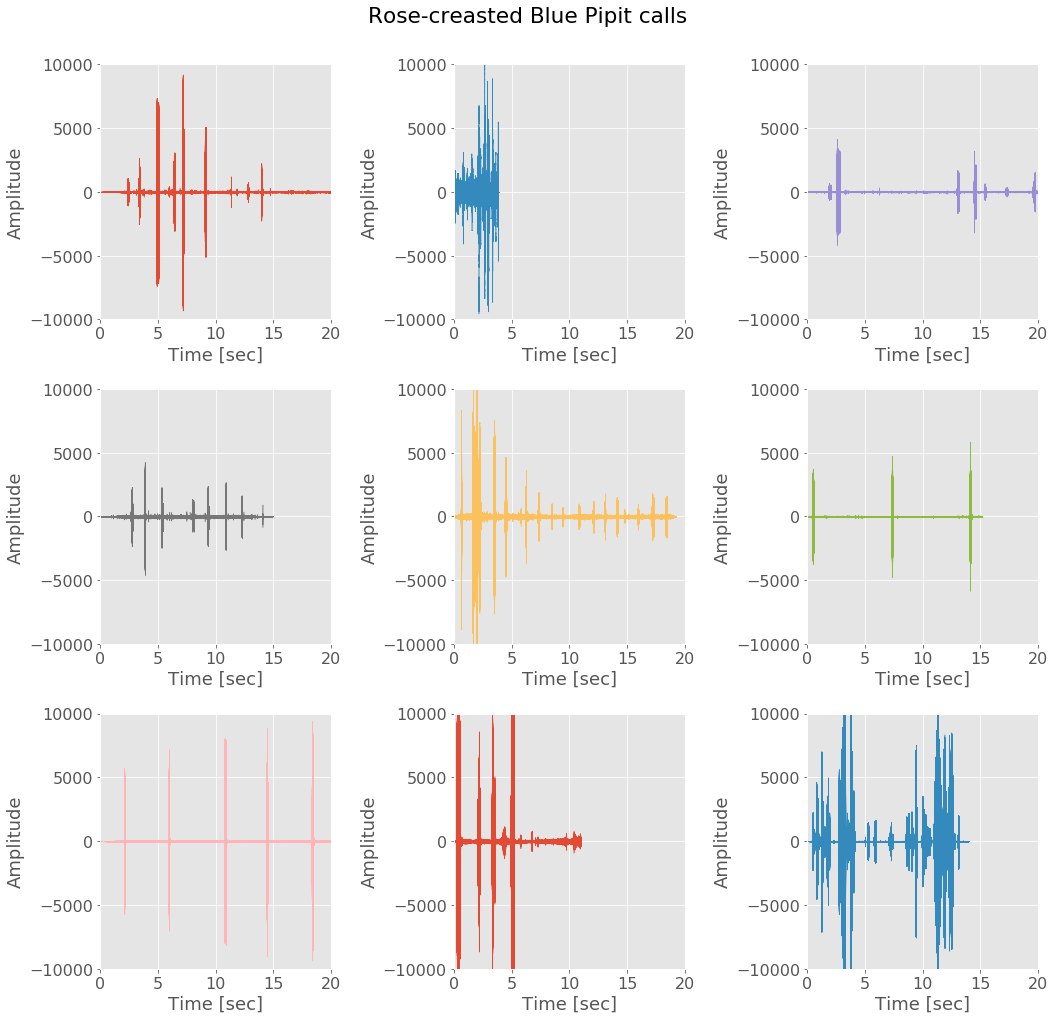

In [8]:
df_bp_calls = df.loc[(df['English_name'] == 'Rose-crested Blue Pipit') 
                    & (df['Vocalization_type'] == 'call')
                    & (df['Quality'] == 'A')]
df_bp_calls = df_bp_calls[:9]


display(df_bp_calls)

plot_signal_temp(df_bp_calls, 
                 title='Rose-creasted Blue Pipit calls')

<div class='alert alert-info'>
From this plot, we can guess the shape of the Blue Pipits calls. 
<br>
We can distinguish the repetition of <strong>high amplitude picks followed by silences</strong>.
<br>
These picks events are the calls. They happen at <strong>regular intervals</strong>. 

</div>

<div class='alert alert-info'>
To conclude, the <strong>difference between songs and calls</strong> of the Blue Pipit is the fact that 
the songs are <strong>longer vocalizations</strong> which usually include a <strong>variety of notes in a sequence</strong>, while bird calls are <strong>short</strong> communications which are often <strong>single notes</strong>.
</div>

### Kasios files

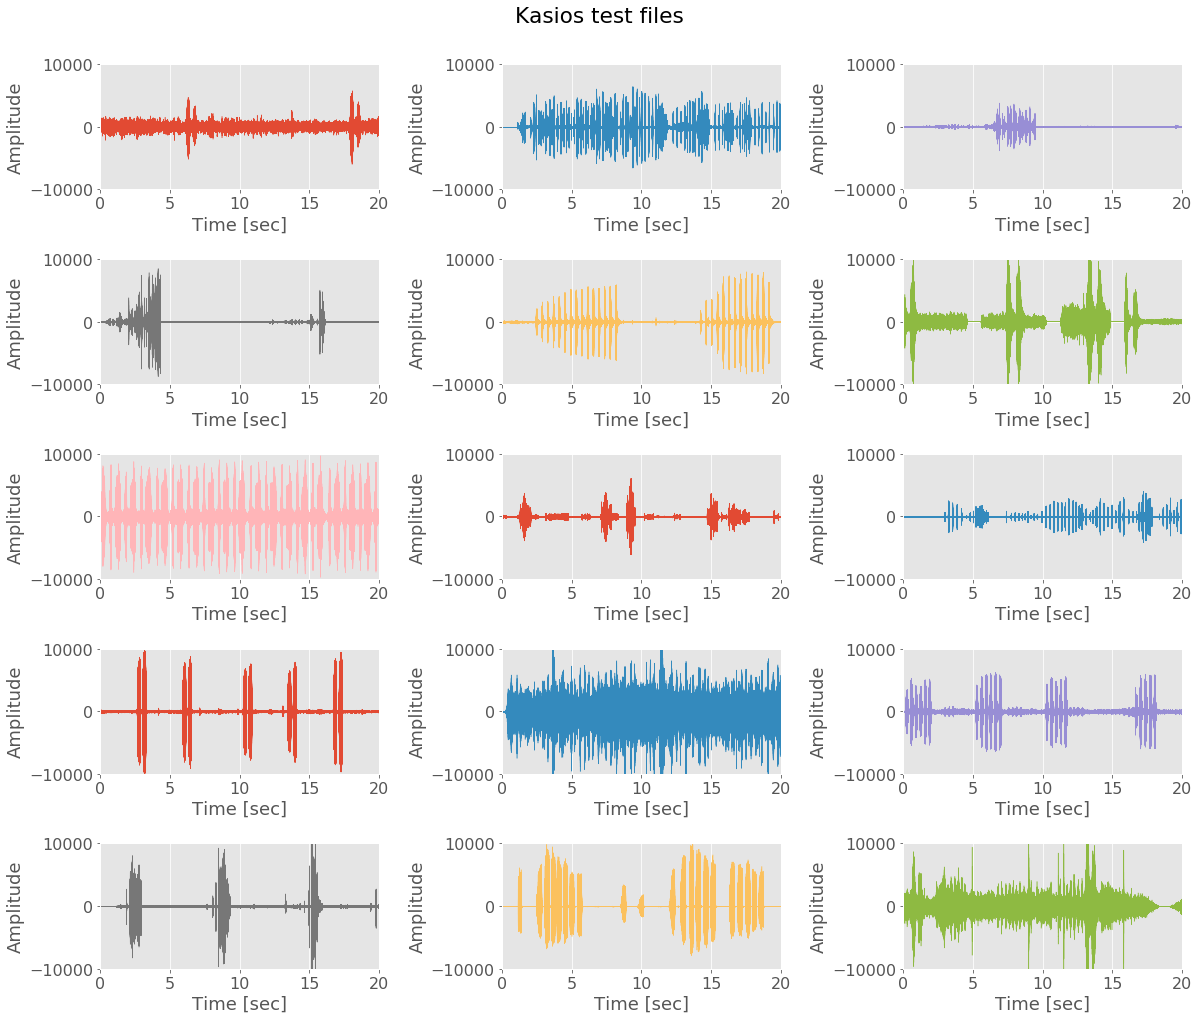

In [13]:
# Get all tests sounds of Kasios
fig = plt.figure(figsize=(17,15))
fig.suptitle('Kasios test files')

for i, (index, obs) in enumerate(df_kasios.iterrows()):
    # read wav file
    rate, data = wavfile.read(obs["song"])
    
    # plot the signal
    ax = fig.add_subplot(5, 3, i+1)
    times = np.arange(len(data))/float(rate)
    ax.fill_between(times, data, color="C{}".format(i%9))
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(0, 20)
    ax.set_ylim(-10000, 10000)
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<div class='alert alert-info'>
Here, we have plotted the 15 test sound of Kasios. They claim that these records are Blue Pipits records.
<br>
From the shapes of Blue Pipit songs and calls we have just described, we can say that <strong>most of the test files do not look like Blue Pipit records</strong>. 
</div>

On the next plot, we emphasize this in focusing on each test sound one by one. We will try to say if it looks similar to a Blue Pipit call or song. 

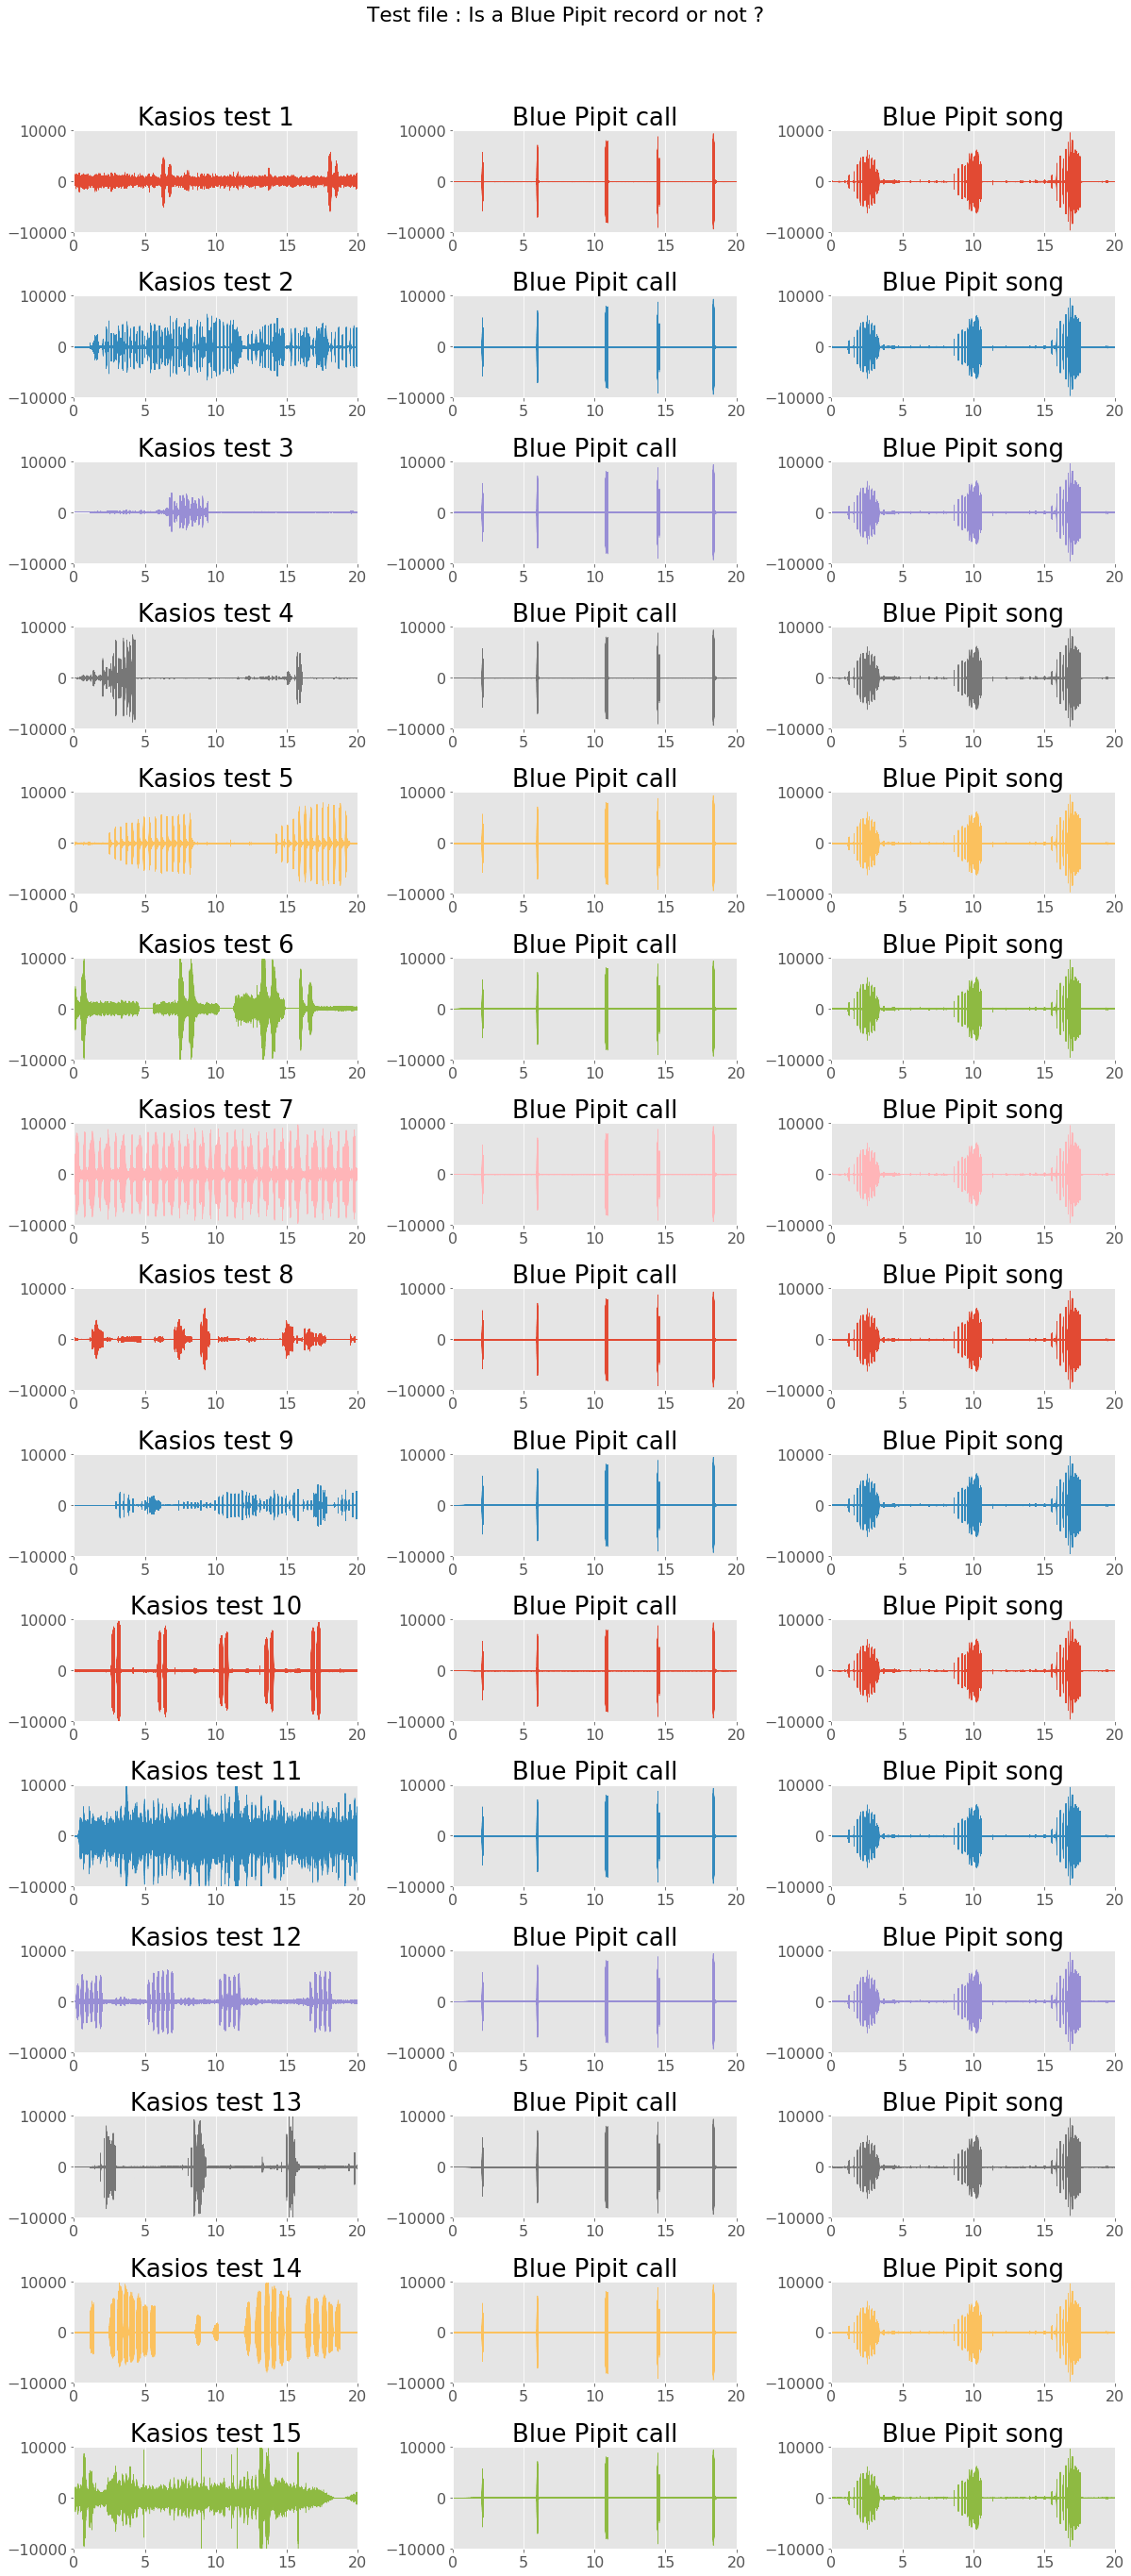

In [14]:
fig = plt.figure(figsize=(17,40))
fig.suptitle('Test file : Is a Blue Pipit record or not ?')

f = df.loc[368492].song
rate_calls, data_calls = wavfile.read(f)
f = df.loc[377874].song
rate_songs, data_songs = wavfile.read(f)


for i, (index, obs) in enumerate(df_kasios.iterrows()):
    # read wav file
    rate, data = wavfile.read(obs["song"])
        
    # visualize the signals 
    ax = fig.add_subplot(15, 3, 3*i+1)
    times = np.arange(len(data))/float(rate)
    title = 'Kasios test {}'.format(i+1)
    ax.fill_between(times, data, color="C{}".format(i%9))
    ax.set_title(title)
    ax.set_xlim(0, 20)
    ax.set_ylim(-10000, 10000)
    
    bx = fig.add_subplot(15, 3, 3*i+2)
    times = np.arange(len(data_calls))/float(rate_calls)
    bx.fill_between(times, data_calls, color="C{}".format(i%9))
    bx.set_title('Blue Pipit call')
    bx.set_xlim(0, 20)
    bx.set_ylim(-10000, 10000)
    
    cx = fig.add_subplot(15, 3, 3*i+3)
    times = np.arange(len(data_songs))/float(rate_songs)
    cx.fill_between(times, data_songs, color="C{}".format(i%9))
    cx.set_title('Blue Pipit song')
    cx.set_xlim(0, 20)
    cx.set_ylim(-10000, 10000)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<table class="table">
  <thead>
    <tr>
      <th scope="col">Test file</th>
      <th scope="col">Looks similar to Blue Pipit</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th scope="row">1</th>
      <td>Yes</td>
    </tr>
    <tr>
      <th scope="row">2</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">3</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">4</th>
      <td>Maybe</td>
    </tr>
    <tr>
      <th scope="row">5</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">6</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">7</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">8</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">9</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">10</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">11</th>
      <td>Maybe</td>
    </tr>
    <tr>
      <th scope="row">12</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">13</th>
      <td>Yes</td>
    </tr>
    <tr>
      <th scope="row">14</th>
      <td>No</td>
    </tr>
    <tr>
      <th scope="row">15</th>
      <td>Yes</td>
    </tr>
  </tbody>
</table>

<div class='alert alert-info'>
Like we previously said, <strong>most of the test records from Kasios does not seem to be from the Rose-Crested-Blue-Pipit species</strong>. But we cannot be sure of the comparison as it is only made by visual interpretation. To be more precise, we could do feature extraction. 
<div>

We may use some visual features in order to discriminate birds sounds such as:

- Minimum and maximum amplitudes.
- Distance between each call.
- Mode of amplitudes.
- Median of amplitudes.
- Range of amplitudes values.
- Variance / Standard Deviation of amplitudes.